# Determine Forest Cover Types

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## Attribute Information - From Dataset Description 


Name / Data Type / Measurement / Description 

Elevation / quantitative /meters / Elevation in meters<br> 
Aspect / quantitative / azimuth / Aspect in degrees azimuth<br> 
Slope / quantitative / degrees / Slope in degrees<br> 
Horizontal_Distance_To_Hydrology / quantitative / meters / Horz Dist to nearest surface water features<br> 
Vertical_Distance_To_Hydrology / quantitative / meters / Vert Dist to nearest surface water features<br>
Horizontal_Distance_To_Roadways / quantitative / meters / Horz Dist to nearest roadway<br> 
Hillshade_9am / quantitative / 0 to 255 index / Hillshade index at 9am, summer solstice<br> 
Hillshade_Noon / quantitative / 0 to 255 index / Hillshade index at noon, summer soltice<br> 
Hillshade_3pm / quantitative / 0 to 255 index / Hillshade index at 3pm, summer solstice<br> 
Horizontal_Distance_To_Fire_Points / quantitative / meters / Horz Dist to nearest wildfire ignition points<br> 
Wilderness_Area (4 binary columns) / qualitative / 0 (absence) or 1 (presence) / Wilderness area designation<br> 
Soil_Type (40 binary columns) / qualitative / 0 (absence) or 1 (presence) / Soil Type designation<br> 
Cover_Type (7 types) / integer / 1 to 7 / Forest Cover Type designation<br>

In [2]:
#Names taken from above
wild_area = ['Wilderness_Area_{}'.format(i) for i in range(1,5)]
soil_type = ['Soil_Type_{}'.format(i) for i in range(1,41)]

names = ['Elevation','Aspect','Slope','Horizontal_Distance_To_Hydrology', 'Vertical_Distance_To_Hydrology',
        'Horizontal_Distance_To_Roadways','Hillshade_9am', 'Hillshade_Noon', 'Hillshade_3pm',
        'Horizontal_Distance_To_Fire_Points']+wild_area + soil_type +['Cover_Type']
data = pd.read_csv('covtype.data', names=names)

data.head()

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,...,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Soil_Type_40,Cover_Type
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


## Data Exploration

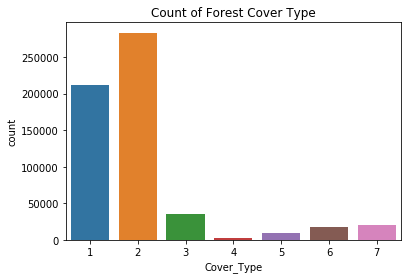

In [3]:
numerical_vals = data.drop(soil_type+wild_area+['Cover_Type'], axis=1)
binary_vals = data[soil_type+wild_area]

params = data.drop(['Cover_Type'], axis=1)
target = data['Cover_Type']

sns.countplot(data['Cover_Type']);
plt.title('Count of Forest Cover Type');

## Consequences of Above Plot
* Clearly classification accuracy will not be sufficient as the classifier could generate fairly decent results by only learning rules for classifying Forest Cover Types 1 & 2
* Will need to ensure that the testing set has enough examples of Cover Types 3-7.

## Build a Balanced Training Set
* Use `StratifiedShuffleSplit` to retrieve training and testing indices of the data while maintaining original class distributions
* Use `resample` to generate a training set from the training indices that equally represents all cover types. The `test_size` paramter in `StratifiedShuffleSplit` will therefore directly determine the number of Cover Type 4 samples in the training and testing sets.
* Put remaining indices back in test set

In [4]:
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.utils import resample

In [5]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5)

for train_index, test_index in sss.split(params, target):
    train_index, test_index = train_index, test_index
    
#Cover Type 4 is the smallest class and therefore determines the number of samples needed from each class to generate
#a training set with balanced class distribution

n_samples = target.loc[train_index][target==4].count()
print 'Number of samples to be taken from each class:\n{}'.format(n_samples)

Number of samples to be taken from each class:
1374


In [6]:
#Create training set with balanced class distributions

train_indices = []
for i in range(1,8):
    train_indices.extend(resample(target.loc[train_index][target==i], replace=False, n_samples=n_samples).index)


test_add = list(set(train_index).difference(set(train_indices)))
test_index = np.append(test_index, test_add)

#Shuffle indices
np.random.shuffle(train_indices)
np.random.shuffle(test_index)

X_train, y_train = params.loc[train_indices], target.loc[train_indices]
X_test, y_test = params.loc[test_index], target.loc[test_index]